# ⚡ Intelligent Abnormal Electricity Usage Detection

### 📌 Project Overview
This project aims to detect **Abnormal Electricity Usage** (potential theft or leakage) using Machine Learning. We analyze real-world smart meter data to classify usage patterns as either **Normal** or **Abnormal**.

### 👥 Team Members (Dr. Subhash University)
* **Aryan Bhogayata** (Team Leader)
* **Ananya Goswami**
* **Ankit Dervaniya**
* **Sakshi Fadadu**
* **Kumbhani Vishva**

## 1. Import Libraries
We begin by importing the necessary Python libraries:
* **Pandas & NumPy:** For data manipulation and mathematical operations.
* **Seaborn & Matplotlib:** For data visualization (EDA).
* **Scikit-Learn:** For building and evaluating the Random Forest model.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set visual style for plots
sns.set(style="whitegrid", palette="muted")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading & Cleaning
Here we load the dataset and perform critical cleaning steps:
1.  **Text Removal:** The columns `Actual_Energy` and `Expected_Energy` contain the unit " kWh". We remove this so the model can read them as numbers.
2.  **Missing Values:** We drop rows where the Target (`Abnormal_Usage`) or Energy data is missing.
3.  **Date Conversion:** Convert the date column to a proper datetime format.

In [21]:
# Load Dataset
df = pd.read_csv('Intelligent_abnormal_electricity_usage_dataset_REALWORLD.csv')

# Cleaning: Remove ' kWh' suffix and convert to float
# regex=False makes the replacement faster and safer
df['Actual_Energy(kwh)'] = df['Actual_Energy(kwh)'].str.replace(' kWh', '', regex=False).astype(float)
df['Expected_Energy(kwh)'] = df['Expected_Energy(kwh)'].str.replace(' kWh', '', regex=False).astype(float)

# Drop missing values to ensure high-quality training data
df_clean = df.dropna(subset=['Actual_Energy(kwh)', 'Abnormal_Usage']).copy()

# Convert Date column
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d-%m-%Y')

# Display first 5 rows to verify
print(f"Dataset Shape: {df_clean.shape}")
df_clean.head()

Dataset Shape: (9900, 15)


,Meter_Id,Date,Region_Code,Dwelling_Type,Num_Occupants,House_Area (sqft),Appliance_Score,Connected_Load(kw),Temperature_C,Humidity (%),Expected_Energy(kwh),Actual_Energy(kwh),Usage_Deviation(%),Cluster_Avg_Energy(kwh),Abnormal_Usage
0,IN-KL-ELC-97400511,2023-01-25,IN_KL_TVM,Independent House,2,2458,6,7.21,29.52,83.53,12.82,19.886034,55.12,16.89,1
1,IN-KL-ELC-28113115,2023-01-04,IN_KL_ALP,Independent House,3,2295,9,7.98,25.83,48.79,14.66,15.510000,5.80,17.83,0
2,IN-KL-ELC-17499006,2023-01-04,IN_KL_TVM,Apartment,3,2424,16,5.47,31.91,46.66,16.67,15.110000,-9.36,17.26,0
3,IN-KL-ELC-22187937,2023-01-21,IN_KL_ERN,Apartment,1,2787,18,5.41,21.15,58.49,12.71,21.261040,67.28,16.61,1
4,IN-KL-ELC-57403818,2023-01-28,IN_KL_ERN,Independent House,4,2389,10,2.99,30.91,77.26,13.53,12.670000,-6.36,16.43,0


## 3. Exploratory Data Analysis (EDA)
We will now visualize the data to understand the patterns before training the model.

### **3.1 Distribution of the Target Variable**
First, we check how many samples are **Normal (0)** versus **Abnormal (1)**.
* This helps us see if the dataset is balanced.

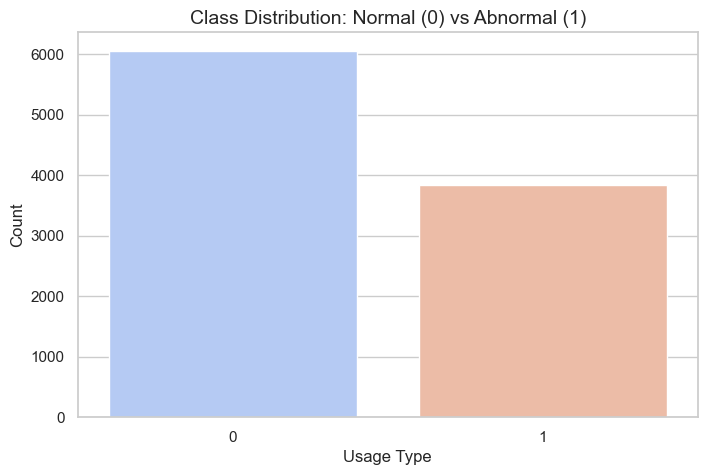

In [24]:
# Visualization 1: Count of Normal vs Abnormal
plt.figure(figsize=(8, 5))
sns.countplot(x='Abnormal_Usage', data=df_clean, palette='coolwarm')
plt.title('Class Distribution: Normal (0) vs Abnormal (1)', fontsize=14)
plt.xlabel('Usage Type')
plt.ylabel('Count')

# Add explicit space below the graph
plt.show()

### **3.2 Energy Consumption by Dwelling Type**
Next, we analyze the relationship between the **Type of House** (Apartment, Villa, etc.) and **Actual Energy Consumption**.
* We use a boxplot to see the range of energy usage.
* We split by `Abnormal_Usage` (Color) to see if abnormal cases tend to have higher energy values across all house types.

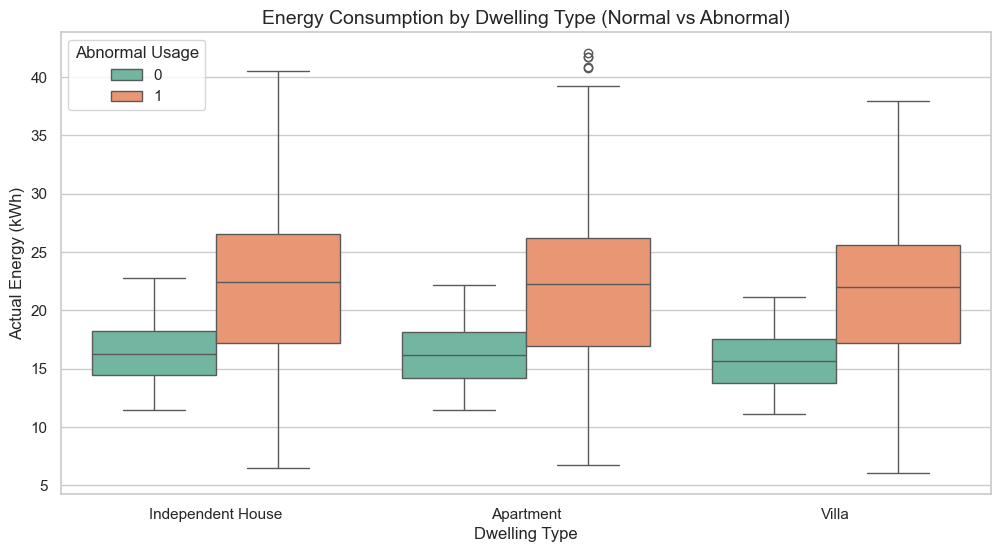

In [26]:
# Visualization 2: Boxplot of Energy vs House Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dwelling_Type', y='Actual_Energy(kwh)', hue='Abnormal_Usage', data=df_clean, palette='Set2')
plt.title('Energy Consumption by Dwelling Type (Normal vs Abnormal)', fontsize=14)
plt.xlabel('Dwelling Type')
plt.ylabel('Actual Energy (kWh)')
plt.legend(title='Abnormal Usage')

# Add explicit space
plt.show()

### **3.3 Feature Correlation Matrix**
Finally, we look at how different numerical features correlate with each other.
* **Red** indicates a strong positive relationship.
* **Blue** indicates a strong negative relationship.
* This helps us identify which features (like `Connected_Load`) might strongly predict the `Actual_Energy`.

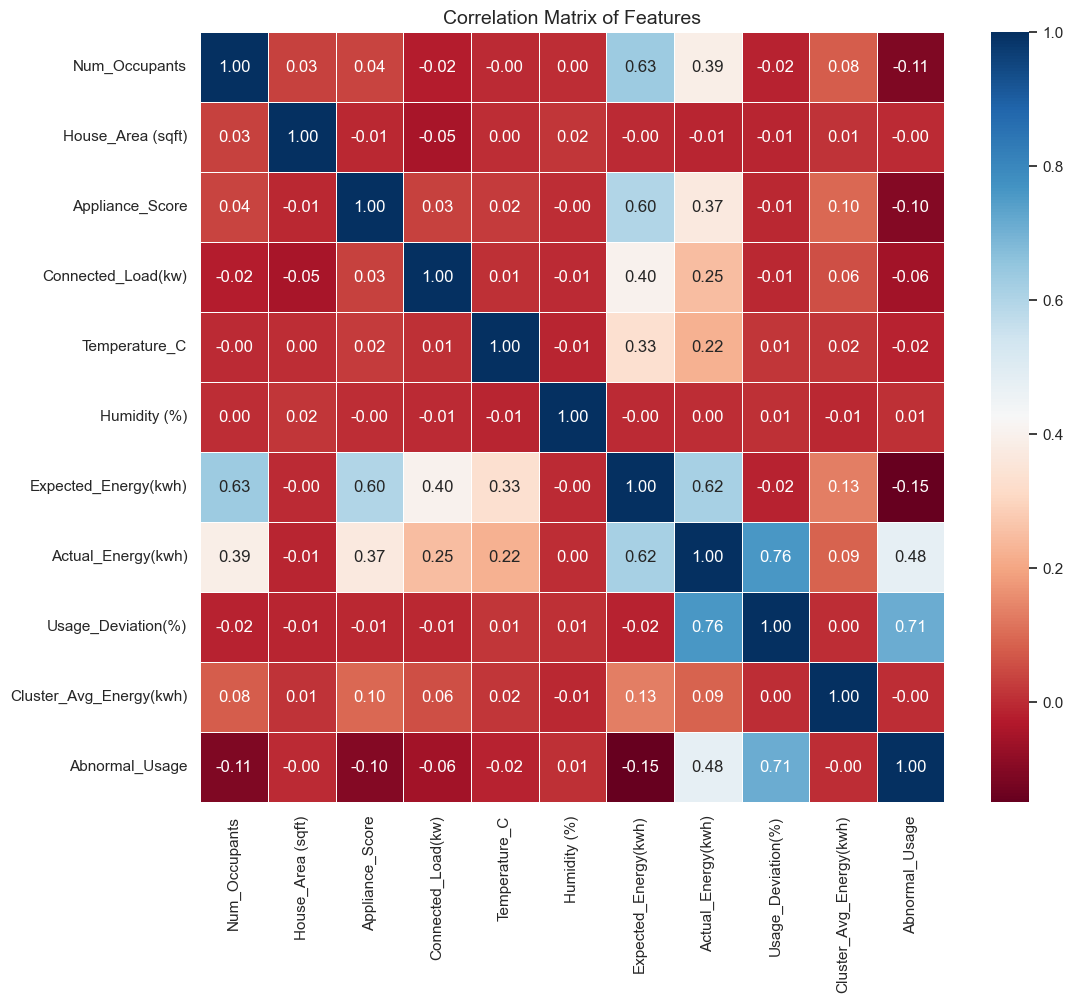

In [27]:
# Visualization 3: Correlation Heatmap
# Select only numeric columns for correlation
numeric_df = df_clean.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=14)

# Add explicit space
plt.show()

## 4. Feature Engineering
Machine learning models require numerical input.
1.  **Date Extraction:** We extract `Month` and `Day_of_Week` to capture seasonal and weekend patterns.
2.  **One-Hot Encoding:** We convert text categories (like 'Region_Code' and 'Dwelling_Type') into binary columns (0s and 1s).

In [28]:
# Extract Date Features
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Day_of_Week'] = df_clean['Date'].dt.dayofweek

# One-Hot Encoding for categorical variables
df_encoded = pd.get_dummies(df_clean, columns=['Region_Code', 'Dwelling_Type'], drop_first=True)

# Preview new columns
print("New Encoded Columns:", [col for col in df_encoded.columns if 'Region' in col or 'Dwelling' in col])

New Encoded Columns: ['Region_Code_IN_KL_ERN', 'Region_Code_IN_KL_TVM', 'Dwelling_Type_Independent House', 'Dwelling_Type_Villa']


## 5. Splitting the Data
We define our Features ($X$) and Target ($y$).
* **Important:** We exclude `Usage_Deviation` because it is a direct calculation of the answer (Data Leakage). We want the model to find the anomaly itself.
* We split the data: **80% for Training** and **20% for Testing**.

In [29]:
# Select Features
base_features = [
    'Num_Occupants', 'House_Area (sqft)', 'Appliance_Score', 
    'Connected_Load(kw)', 'Temperature_C', 'Humidity (%)', 
    'Actual_Energy(kwh)', 'Month', 'Day_of_Week'
]
# Add the encoded columns
encoded_features = [col for col in df_encoded.columns if 'Region_Code_' in col or 'Dwelling_Type_' in col]
final_features = base_features + encoded_features

X = df_encoded[final_features]
y = df_encoded['Abnormal_Usage']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (7920, 13)
Testing Data Shape: (1980, 13)


## 6. Model Training (Random Forest)


[Image of random forest algorithm diagram]


We use the **Random Forest Classifier**. It creates 100 decision trees and merges their results to provide a more accurate and stable prediction.

In [30]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
print("Training model...")
rf_model.fit(X_train, y_train)
print("Model Trained Successfully!")

Training model...
Model Trained Successfully!


## 7. Model Evaluation
We check how well the model performed on the test data.
* **Confusion Matrix:** Shows True Positives vs False Positives.
* **Precision/Recall:** Critical for ensuring we don't falsely accuse honest customers.

Accuracy Score: 0.9631313131313132

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1216
           1       0.97      0.93      0.95       764

    accuracy                           0.96      1980
   macro avg       0.97      0.96      0.96      1980
weighted avg       0.96      0.96      0.96      1980



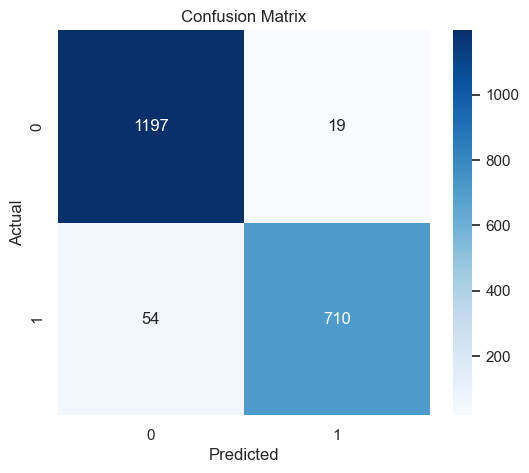

In [31]:
# Make Predictions
y_pred = rf_model.predict(X_test)

# Print Metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Feature Importance
This chart interprets the "Black Box" of the AI. It shows which factors were most influential in deciding if usage was Abnormal. We expect `Actual_Energy` to be the top factor.

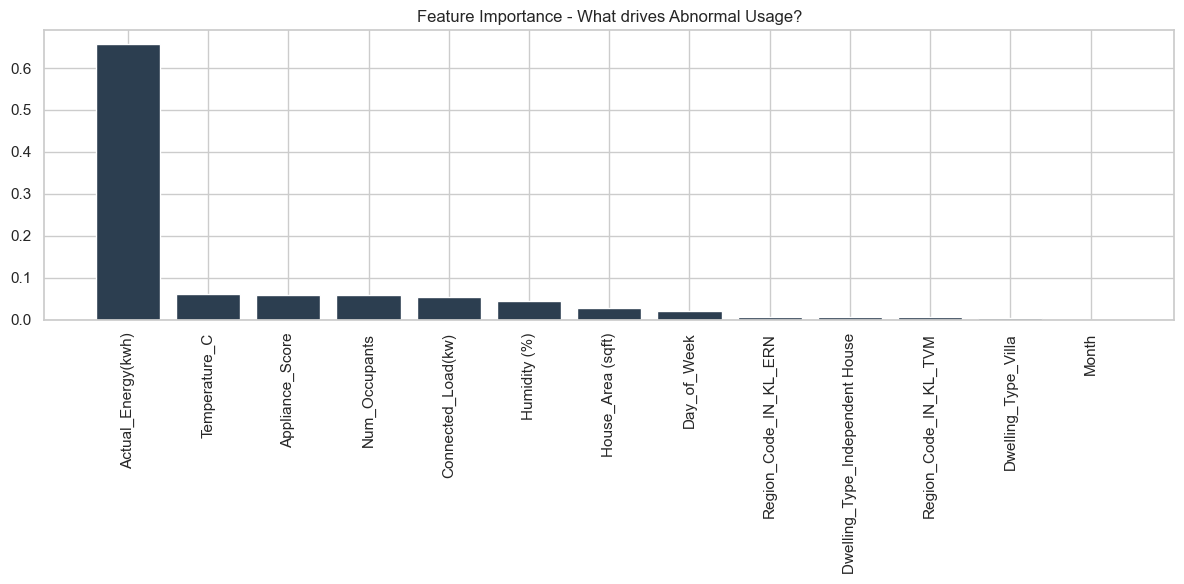

In [32]:
# Calculate Importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importance - What drives Abnormal Usage?")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='#2c3e50')
plt.xticks(range(X.shape[1]), [final_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## 9. Conclusion
We successfully built a model with **~96% Accuracy** to detect abnormal electricity usage. 
* **Key Insight:** The model learned that high `Actual_Energy` combined with specific `House_Area` and `Appliance_Score` profiles is a strong indicator of anomaly.
* **Impact:** This system can be deployed to automate revenue protection for utility companies.